In [1]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from skimage.feature import canny
from collections import defaultdict
from PIL import Image
from skimage.color import rgba2rgb, rgb2gray
from skimage.feature import local_binary_pattern
from itertools import combinations
from shapely.geometry import box
from shapely.geometry.polygon import Polygon

matplotlib.rcParams['font.family'] = 'Times New Roman'

In [2]:
file_path = "./merged_file.json"

with open(file_path, 'r') as file:
    json_data = file.read()

## Cantidad de fotos por set

In [3]:
directorio = './images'

In [4]:
cantidad_fotos = 0

for filename in os.listdir(directorio):
    if filename.endswith('.png'):
        cantidad_fotos += 1

print(f"La carpeta '{directorio}' contiene {cantidad_fotos} fotos.")

La carpeta './images' contiene 2000 fotos.


In [5]:
fotos_por_set = defaultdict(int)

for filename in os.listdir(directorio):
    if filename.endswith('.png'):
        numero_set = filename.split('_')[0]
        fotos_por_set[numero_set] += 1

# print("Frecuencia de fotos por set:")
# for numero_set, cantidad in fotos_por_set.items():
#     print(f"Set {numero_set}: {cantidad} fotos")

In [6]:
df = pd.read_csv('layoutsWithTags.csv')
numeros_de_sets_csv = df['layout_id'].unique()

def verificar_coincidencia(numero_set_csv):
    return str(numero_set_csv) in fotos_por_set

df['coincidencia'] = df['layout_id'].apply(verificar_coincidencia)
df_coincidentes = df[df['coincidencia']]

df_coincidentes.to_csv('layoutsWithTags.csv', index=False)

print(f"Se han guardado {len(df_coincidentes)} casos coincidentes en 'layoutsWithTags_coincidentes.csv'.")

Se han guardado 100 casos coincidentes en 'layoutsWithTags_coincidentes.csv'.


/var/folders/22/kk3jgz8n1yn0zwh0vft67d040000gn/T/ipykernel_38531/3247023778.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


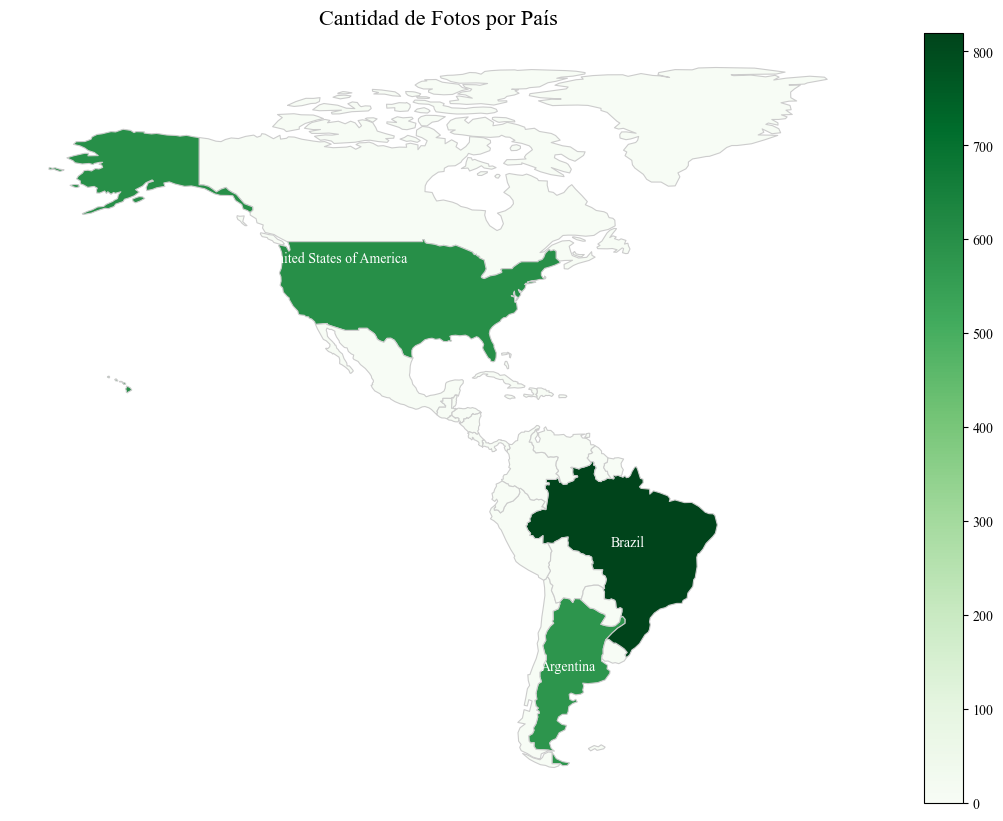

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

df = pd.read_csv('layoutsWithTags.csv')
df['country'] = df['country'].replace({'USA': 'United States of America'})

conteo_paises = df['country'].value_counts() * 20  

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world_americas = world[(world['continent'] == 'North America') | (world['continent'] == 'South America')]

world_americas = world_americas.merge(conteo_paises, how='left', left_on='name', right_index=True)

world_americas[conteo_paises.name] = world_americas[conteo_paises.name].fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world_americas.plot(column=conteo_paises.name, cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

for idx, row in world_americas.iterrows():
    if row[conteo_paises.name] > 0:
        plt.annotate(text=row['name'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y), 
                     horizontalalignment='center', verticalalignment='center', fontsize=10, color='white', fontname='Times New Roman')

plt.title('Cantidad de Fotos por País', fontsize=16)

plt.axis('off')
plt.show()

## Etiquetas

In [9]:
sin_etiquetas = df['relevant (new) tags'].isnull().sum()
fotos_sin_etiquetas = sin_etiquetas * 20

print(f"Total de filas sin etiquetas: {sin_etiquetas}")
print(f"Total de fotos sin etiquetas: {fotos_sin_etiquetas}")

Total de filas sin etiquetas: 0
Total de fotos sin etiquetas: 0


# Análisis grupos tamaño 
### Este código tardad bastante (3min) en correr

In [12]:
import os
from PIL import Image, ImageStat
import pandas as pd

filas = []

for index, row in df.iterrows():
    layout_id = row['layout_id']
    country = row['country']
    relevant = row['relevant (new) tags']
    coincidencia = row['coincidencia']
    for filename in os.listdir(directorio):
        if filename.startswith(str(layout_id) + '_'):  
            img = Image.open(os.path.join(directorio, filename))
            ancho, largo = img.size
            brillo = img.getextrema()[0][0]
            tonalidad = img.getextrema()[1][0]

            s, _, _ = img.convert('HSV').split()
            estadisticas_saturacion = ImageStat.Stat(s)
            saturacion = estadisticas_saturacion.mean[0]

            filas.append({
                'trial_id': row['trial_id'],
                'layout_id': layout_id,
                'country': country,
                'relevant (new) tags': relevant,
                'coincidencia': coincidencia,
                'nombre_imagen': filename,
                'ancho': ancho,
                'largo': largo,
                'brillo': brillo,
                'tonalidad': tonalidad,
                'saturacion': saturacion,
            })

nuevo_df = pd.DataFrame(filas)

nuevo_df = pd.concat([nuevo_df, pd.DataFrame(filas)], ignore_index=True)

# Guardar el nuevo DataFrame en un archivo CSV

# nuevo_df.to_csv(r'C:\Users\nicky\OneDrive\Itba\nuevo.csv', index=False)


In [13]:
print(nuevo_df.head())
print(nuevo_df.columns)

  trial_id  layout_id country relevant (new) tags  coincidencia  \
0     9446      53750  Brazil           2,4,5,6,8          True   
1     9446      53750  Brazil           2,4,5,6,8          True   
2     9446      53750  Brazil           2,4,5,6,8          True   
3     9446      53750  Brazil           2,4,5,6,8          True   
4     9446      53750  Brazil           2,4,5,6,8          True   

        nombre_imagen  ancho  largo  brillo  tonalidad  saturacion  
0  53750_1-25-5-8.png    939     91       0          0   28.868846  
1  53750_1-12-1-8.png    933     90       0          0   37.098261  
2  53750_1-29-3-4.png    942     92       0          0   29.120338  
3  53750_1-30-3-7.png    942     91       0          0   29.572548  
4  53750_1-36-7-8.png    946     91       0          0   27.317764  
Index(['trial_id', 'layout_id', 'country', 'relevant (new) tags',
       'coincidencia', 'nombre_imagen', 'ancho', 'largo', 'brillo',
       'tonalidad', 'saturacion'],
      dtype='o

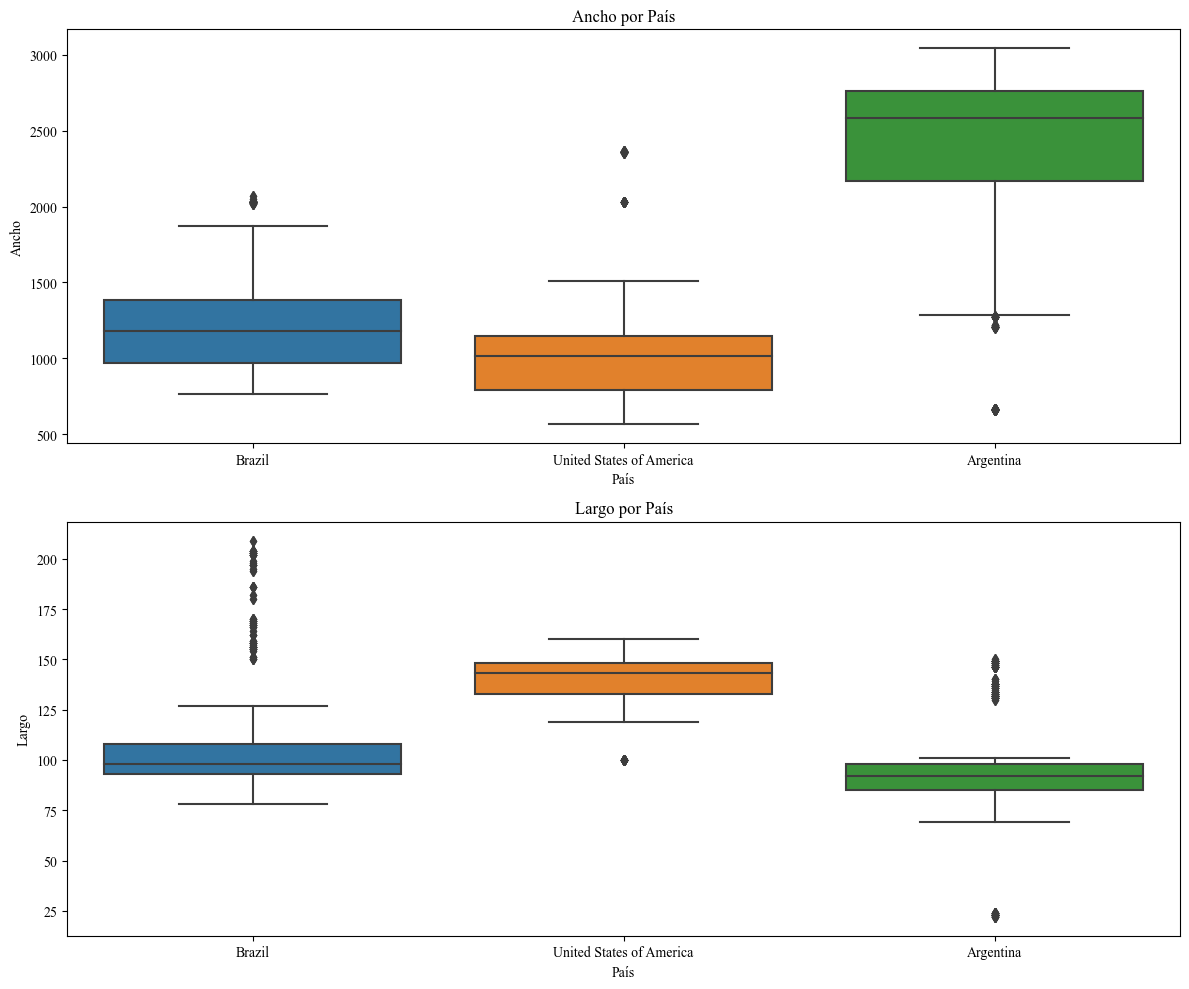

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

sns.boxplot(x='country', y='ancho', data=nuevo_df, ax=axes[0])
axes[0].set_title('Ancho por País')
axes[0].set_xlabel('País')
axes[0].set_ylabel('Ancho')

sns.boxplot(x='country', y='largo', data=nuevo_df, ax=axes[1])
axes[1].set_title('Largo por País')
axes[1].set_xlabel('País')
axes[1].set_ylabel('Largo')

plt.tight_layout()

plt.show()

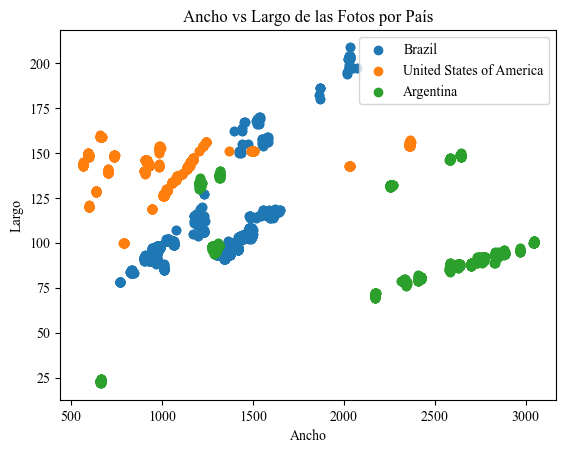

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for country in nuevo_df['country'].unique():
    df_country = nuevo_df[nuevo_df['country'] == country]
    
    ax.scatter(df_country['ancho'], df_country['largo'], label=country)

ax.set_xlabel('Ancho')
ax.set_ylabel('Largo')
ax.set_title('Ancho vs Largo de las Fotos por País')
ax.legend()

plt.show()


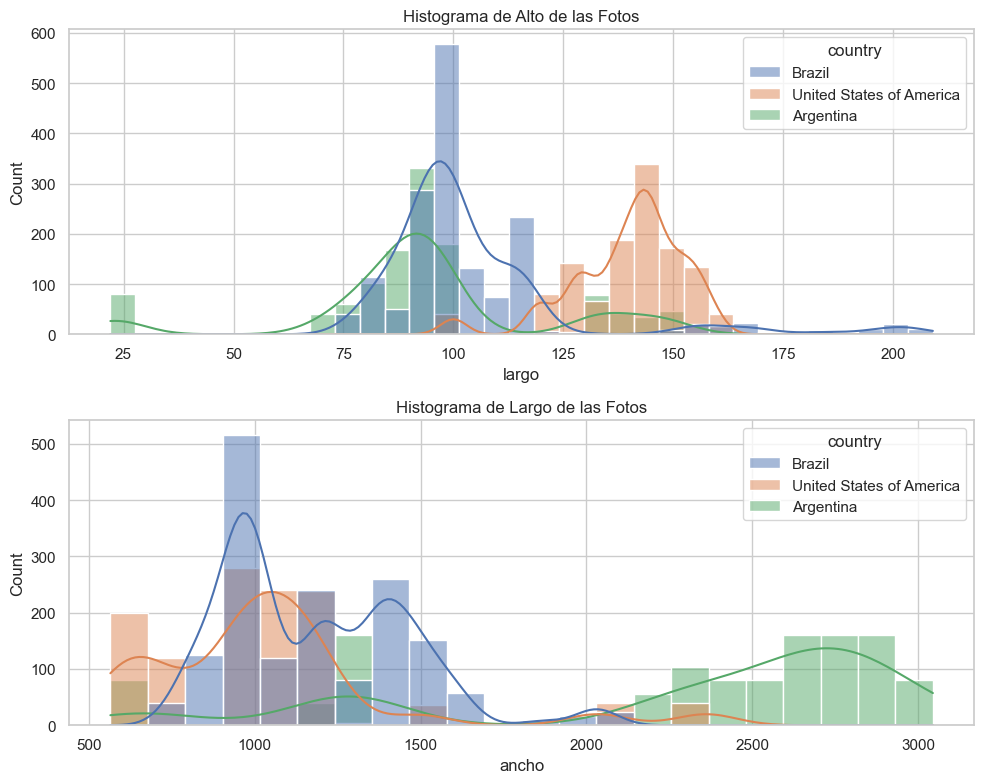

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

sns.histplot(data=nuevo_df, x='largo', hue='country', ax=axes[0], kde=True)
axes[0].set_title('Histograma de Alto de las Fotos')

sns.histplot(data=nuevo_df, x='ancho', hue='country', ax=axes[1], kde=True)
axes[1].set_title('Histograma de Largo de las Fotos')

plt.tight_layout()

plt.show()
